## 2.3 Experiment of NEURAL OBLIVIOUS DECISION ENSEMBLES (NODE) on MoA dataset

In [1]:
# !git clone https://github.com/Qwicen/node.git
# !pip install -r node/requirements.txt
# !pip install qhoptim

# only need this one
! pip install iterative-stratification

In [2]:
import sys, os
import gc
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional
from tqdm.notebook import tqdm
from time import time
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow_addons as tfa
import tensorflow_probability as tfp

from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

Run the following cell if you want to use GDrive (file stored under `/content/drive/MyDrive/Colab Notebooks/MoA-Prediction/moa_data/`.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# path in GDrive
# data_path = "/content/drive/MyDrive/Colab Notebooks/MoA/lish-moa/"

# path
data_path = "/content/drive/MyDrive/Colab Notebooks/MoA-Prediction/moa_data/"
data_file_list = ["train_features.csv", "test_features.csv", "train_targets_scored.csv", \
                  "train_targets_nonscored.csv"]

# load data
data_train = pd.read_csv(data_path + data_file_list[0])
data_test = pd.read_csv(data_path + data_file_list[1])
train_targets_scored = pd.read_csv(data_path + data_file_list[2])
train_targets_nonscored = pd.read_csv(data_path + data_file_list[3])

# data info
print(f'Training features file: {data_train.shape[0]} rows; {data_train.shape[1]} columns')
print(f'Testing features file: {data_test.shape[0]} rows; {data_test.shape[1]} columns')
print(f'Training targets scored file: {train_targets_scored.shape[0]} rows; \
{train_targets_scored.shape[1]} columns')
print(f'Training targets nonscored file: {train_targets_nonscored.shape[0]} rows; \
{train_targets_nonscored.shape[1]} columns')

Training features file: 23814 rows; 876 columns
Testing features file: 3982 rows; 876 columns
Training targets scored file: 23814 rows; 207 columns
Training targets nonscored file: 23814 rows; 403 columns


In [5]:
data_train.head(3)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


In [6]:
data_test.head(3)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.214,0.2221,-0.3260,1.9390,-0.2305,-0.3670,1.304,1.4610,0.0043,0.6816,-0.2304,-0.0635,-0.2030,-0.6821,-0.6242,0.1297,-0.0338,0.3372,0.2254,0.4795,0.7642,0.6638,-0.2480,-0.1183,-0.4847,-0.0179,-0.8204,-0.5296,-1.5070,-0.0144,...,-0.1353,0.0494,0.8939,0.227,0.2876,-0.3065,0.6519,-0.8156,-1.4960,0.3796,0.0877,-1.0230,-0.0206,-0.4149,-0.6258,-0.2688,0.4403,-0.4900,0.2910,0.0473,-0.0914,0.3087,-0.0612,-0.9128,-0.9399,0.0173,0.0519,-0.0035,-0.5184,-0.3485,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.882,0.4022,-0.3528,0.1271,0.9303,0.3173,-1.012,-0.3213,0.0607,-0.5389,-0.8030,-1.0600,-0.0978,-0.8156,-0.6514,0.6812,0.5246,0.0000,0.5030,-0.1500,-0.1433,2.0910,-0.6556,-0.6012,-0.4104,-0.0580,-0.3608,0.2197,-0.7101,1.3430,...,-0.7458,0.0458,-0.3644,-1.818,-0.0358,-0.7925,-0.2693,-0.0938,-0.1833,-0.7402,-1.4090,0.1987,0.0460,-1.3520,-0.3445,-0.0909,-0.6337,-0.5788,-0.7885,0.0996,-1.9480,-1.2720,-0.7223,-0.5838,-1.3620,-0.7671,0.4881,0.5913,-0.4333,0.1234,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,-0.339,-0.3206,0.6944,0.5837,-0.0553,-0.6222,2.543,-0.7857,0.8163,-0.0495,0.1806,1.0290,-0.5204,-1.1070,0.7365,-0.3835,-0.5771,0.0523,-0.2690,0.1674,0.6010,-0.6660,0.0276,0.0924,0.2785,-0.3943,-0.4602,-0.0673,-1.3420,0.3127,...,0.4369,-1.4960,1.2390,-1.222,0.6624,-0.7336,-0.5248,0.0727,0.1455,0.5364,-0.0823,0.5734,0.4876,0.7088,1.0750,0.4689,1.0870,-0.5036,-0.3451,0.5087,1.1100,0.7886,0.2093,-0.4617,1.4870,0.1985,1.1750,-0.5693,0.5062,-0.1925,-0.2261,0.3370,-1.384,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942


In [7]:
train_targets_scored.sample(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
10013,id_6becd24f6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9127,id_6212cde8e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
392,id_042e03163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
data_train.cp_type.value_counts(normalize=True)

trt_cp         0.921643
ctl_vehicle    0.078357
Name: cp_type, dtype: float64

In [9]:
control_group = data_train.loc[data_train.cp_type == 'ctl_vehicle']
control_group['sig_id'].count()

1866

**Summary**:

7.8357% samples in the original dataset were treated as the control perturbation => 1866 samples out of total sample pool of 23814. In the dataset, cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); Since **control perturbations have no MoAs**, samples (sig_id) with this cp_type will be droped from training. 

### Pre-processing

In [10]:
# define helper functions data pre-processing

def df_pre_processing(raw_df, type='training', verbose=True):
    # expand features 2 non-numerical features 'cp_type', 'cp_dose' to 4 dummy 
    # features based on categorical values 
    processed_df = pd.concat([raw_df, pd.get_dummies(raw_df['cp_dose'], prefix='cp_dose')], axis=1)
    processed_df = pd.concat([processed_df, pd.get_dummies(raw_df['cp_type'], \
                                                                           prefix='cp_type')], axis=1)

    # drop the three original features
    processed_df = processed_df.drop(['cp_type', 'cp_dose'], axis=1)

    # removed the samples with wrong cp_type -- removed 1866 samples
    processed_df = processed_df.loc[processed_df['cp_type_trt_cp']==1].reset_index(drop=True)
    
    # drop the original sig_id column
    processed_df = processed_df.drop(columns='sig_id')

    # show shape of processed df
    if verbose:
        print(f"Processed {type} dataset shape = {processed_df.shape}.")
        
    return processed_df

# apply on both training and test dataset
data_train_processed = df_pre_processing(raw_df=data_train)
data_test_processed = df_pre_processing(raw_df=data_test, type='test')

data_train_processed.head(3)

Processed training dataset shape = (21948, 877).
Processed test dataset shape = (3624, 877).


,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,...,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,cp_dose_D1,cp_dose_D2,cp_type_ctl_vehicle,cp_type_trt_cp
0,24,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,-0.5119,...,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,0,0,1
1,72,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,0.1656,0.5300,-0.2568,...,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,1,0,0,1
2,48,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,0.1256,-0.1219,5.4470,...,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,1,0,0,1


In [41]:
# define helper functions for traget multi-binary-label classification metric

def metric(y_true, y_pred, df_train_targets):
    metrics = []
    for _target in df_train_targets.columns:
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels=[0,1]))
    return np.mean(metrics)

def get_average_metrics_out_of_cv_folds(history_list):
    """ Derive total number of folds and total number epochs"""
    total_n_folds = len(history_list)
    total_epochs = len(hist_total_list[0].history['loss'])
    mean_loss = np.zeros([total_n_folds,total_epochs])
    mean_val_loss = np.zeros([total_n_folds,total_epochs])
    
    # Put loss and validation loss in each fold
    for i in range(total_n_folds):
        mean_loss[i,:] = history_list[i].history['loss']
        mean_val_loss[i,:] = history_list[i].history['val_loss']

    # Get average loss and validation loss
    mean_loss = np.mean(mean_loss,axis=0)
    mean_val_loss  = np.mean(mean_val_loss ,axis=0)
    return mean_loss, mean_val_loss

In [42]:
# removed the samples with wrong cp_type on the training targets scored dataset

train_targets_w_id = train_targets_scored.loc[data_train['cp_type']=='trt_cp'].reset_index(drop=True)

# drop the original sig_id column
train_targets = train_targets_w_id.drop(columns='sig_id')

print(f"The processed training targets scored data shape = {train_targets.shape}.")

The processed training targets scored data shape = (21948, 206).


### Implementation of NODE based on tf.keras framework 

In [43]:
@tf.function
def sparsemoid(inputs: tf.Tensor):
    return tf.clip_by_value(0.5 * inputs + 0.5, 0., 1.)

@tf.function
def identity(x: tf.Tensor):
    return x

class ODST(tf.keras.layers.Layer):
    def __init__(self, n_trees: int = 3, depth: int = 4, units: int = 1, threshold_init_beta: float = 1.):
        super(ODST, self).__init__()
        self.initialized = False
        self.n_trees = n_trees
        self.depth = depth
        self.units = units
        self.threshold_init_beta = threshold_init_beta
    
    def build(self, input_shape: tf.TensorShape):
        feature_selection_logits_init = tf.zeros_initializer()
        self.feature_selection_logits = tf.Variable(initial_value=feature_selection_logits_init(shape=(input_shape[-1], self.n_trees, self.depth), dtype='float32'),
                                 trainable=True)        
        
        feature_thresholds_init = tf.zeros_initializer()
        self.feature_thresholds = tf.Variable(initial_value=feature_thresholds_init(shape=(self.n_trees, self.depth), dtype='float32'),
                                 trainable=True)
        
        log_temperatures_init = tf.ones_initializer()
        self.log_temperatures = tf.Variable(initial_value=log_temperatures_init(shape=(self.n_trees, self.depth), dtype='float32'),
                                 trainable=True)
        
        indices = tf.keras.backend.arange(0, 2 ** self.depth, 1)
        offsets = 2 ** tf.keras.backend.arange(0, self.depth, 1)
        bin_codes = (tf.reshape(indices, (1, -1)) // tf.reshape(offsets, (-1, 1)) % 2)
        bin_codes_1hot = tf.stack([bin_codes, 1 - bin_codes], axis=-1)
        self.bin_codes_1hot = tf.Variable(initial_value=tf.cast(bin_codes_1hot, 'float32'), 
                                          trainable=False)
        
        response_init = tf.ones_initializer()
        self.response = tf.Variable(initial_value=response_init(shape=(self.n_trees, self.units, 2**self.depth), dtype='float32'), 
                                    trainable=True)
                
    def initialize(self, inputs):        
        feature_values = self.feature_values(inputs)
        
        # intialize feature_thresholds
        percentiles_q = (100 * tfp.distributions.Beta(self.threshold_init_beta, 
                                                      self.threshold_init_beta)
                         .sample([self.n_trees * self.depth]))
        flattened_feature_values = tf.map_fn(tf.keras.backend.flatten, feature_values)
        init_feature_thresholds = tf.linalg.diag_part(tfp.stats.percentile(flattened_feature_values, percentiles_q, axis=0))
        
        self.feature_thresholds.assign(tf.reshape(init_feature_thresholds, self.feature_thresholds.shape))
        
        # intialize log_temperatures
        self.log_temperatures.assign(tfp.stats.percentile(tf.math.abs(feature_values - self.feature_thresholds), 50, axis=0))
        
    def feature_values(self, inputs: tf.Tensor, training: bool = None):
        feature_selectors = tfa.activations.sparsemax(self.feature_selection_logits)
        # ^--[in_features, n_trees, depth]

        feature_values = tf.einsum('bi,ind->bnd', inputs, feature_selectors)
        # ^--[batch_size, n_trees, depth]
        
        return feature_values
        
    def call(self, inputs: tf.Tensor, training: bool = None):
        if not self.initialized:
            self.initialize(inputs)
            self.initialized = True
            
        feature_values = self.feature_values(inputs)
        
        threshold_logits = (feature_values - self.feature_thresholds) * tf.math.exp(-self.log_temperatures)

        threshold_logits = tf.stack([-threshold_logits, threshold_logits], axis=-1)
        # ^--[batch_size, n_trees, depth, 2]

        bins = sparsemoid(threshold_logits)
        # ^--[batch_size, n_trees, depth, 2], approximately binary

        bin_matches = tf.einsum('btds,dcs->btdc', bins, self.bin_codes_1hot)
        # ^--[batch_size, n_trees, depth, 2 ** depth]

        response_weights = tf.math.reduce_prod(bin_matches, axis=-2)
        # ^-- [batch_size, n_trees, 2 ** depth]

        response = tf.einsum('bnd,ncd->bnc', response_weights, self.response)
        # ^-- [batch_size, n_trees, units]
        
        return tf.reduce_sum(response, axis=1)
    
class NODE(tf.keras.Model):
    def __init__(self, units: int = 1, n_layers: int = 1, output_dim = 1, dropout_rate = 0.1, link: tf.function = tf.identity, n_trees: int = 3, depth: int = 4, threshold_init_beta: float = 1., feature_column: Optional[tf.keras.layers.DenseFeatures] = None):
        super(NODE, self).__init__()
        self.units = units
        self.n_layers = n_layers
        self.n_trees = n_trees
        self.depth = depth
        self.units = units
        self.threshold_init_beta = threshold_init_beta
        self.feature_column = feature_column
        self.dropout_rate = dropout_rate
        self.output_dim = output_dim
        
        if feature_column is None:
            self.feature = tf.keras.layers.Lambda(identity)
        else:
            self.feature = feature_column
        
        self.bn = [tf.keras.layers.BatchNormalization() for _ in range(n_layers + 1)]
        self.dropout = [tf.keras.layers.Dropout(self.dropout_rate) for _ in range(n_layers + 1)]
        self.ensemble = [ODST(n_trees = n_trees,
                              depth = depth,
                              units = units,
                              threshold_init_beta = threshold_init_beta) 
                         for _ in range(n_layers)]
        
        self.last_layer = tf.keras.layers.Dense(self.output_dim)
        
        self.link = link
        
    def call(self, inputs, training=None):
        X = self.feature(inputs)
        X = self.bn[0](X, training=training)
        X = self.dropout[0](X, training=training)
        
        for i, tree in enumerate(self.ensemble):
            H = tree(X)
            X = tf.concat([X, H], axis=1)
            X = self.bn[i + 1](X, training=training)
            X = self.dropout[i + 1](X, training=training)
            
        return self.link(self.last_layer(X))

In [44]:
def create_NODE(n_layers, units, output_dim, dropout_rate, depth, n_trees, link, learning_rate):
    """
    """
    node = NODE(n_layers = n_layers, units = units, output_dim = output_dim, dropout_rate = dropout_rate, 
                depth = depth, n_trees = n_trees, link = tf.keras.activations.sigmoid)
    
    node.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), 
                 loss = 'binary_crossentropy')
    return node

## Train model

In [55]:
N_STARTS = 1
N_SPLITS = 3

df_residual = train_targets.copy()
df_residual.loc[:, train_targets.columns] = 0
hist_total_list = []

for seed in range(N_STARTS):
    start_time_seed = time()
    K.clear_session()
    tf.random.set_seed(seed)
    mean_score = 0
    skf = MultilabelStratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
    
    for n, (tr, te) in enumerate(skf.split(train_targets, train_targets)):
        start_time_fold = time()
        x_tr, x_val = data_train_processed.values[tr], data_train_processed.values[te]
        y_tr, y_val = train_targets.values[tr], train_targets.values[te]
        
        # NODE model instance
        model = create_NODE(n_layers=5, units=128, output_dim=206, dropout_rate=0.1, depth=6, 
                            n_trees=3, link=tf.keras.activations.sigmoid, learning_rate=1e-3)
        # adaptive alpha, change learning rate
        rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, 
                                min_delta=1e-4, mode = 'min')
        # set early stop 
        es = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='min', 
                           baseline=None, restore_best_weights=True, verbose=0)
        history = model.fit(x_tr, y_tr, validation_data = (x_val, y_val), epochs=10, 
                            batch_size=128, callbacks=[rlr, es], verbose=0)
        
        hist_total_list.append(history)
        hist = pd.DataFrame(history.history)
        fold_score = hist['val_loss'].min()
        mean_score += fold_score / N_SPLITS
        val_predict = model.predict(data_train_processed.values[te])
        
        df_residual.loc[te, train_targets.columns] += val_predict / N_STARTS
        print(f'[{str(datetime.timedelta(seconds = time()-start_time_fold))[2:7]}] \
        NODE Seed {seed}, Fold {n}:', fold_score)
        
    print(f'[{str(datetime.timedelta(seconds = time()-start_time_seed))[2:7]}] \
    NODE Seed {seed} Mean Score:', mean_score)

[01:44]         NODE Seed 0, Fold 0: 0.017650512978434563
[01:43]         NODE Seed 0, Fold 1: 0.0175186637789011
[01:42]         NODE Seed 0, Fold 2: 0.01755169779062271
[05:12]     NODE Seed 0 Mean Score: 0.017573624849319458


In [ ]:
# new version 


In [46]:
print(res.shape)
print(train_targets.shape)

(21948, 206)
(21948, 206)


Note on expt:

- performance baseline: 0.017787196522898216
- sigmoid to softmax: 
    - no change 
- n_tree
- n_layer
    - change from 3 to 5: 0.017573646823844536
- depth

In [57]:
print(f'NODE OOF Metric: {metric(train_targets, df_residual, train_targets)}')

NODE OOF Metric: 0.017573646823844536


In [47]:
# node baseline, DON'T remove 

print(f'NODE OOF Metric: {metric(train_targets, res, train_targets)}')

NODE OOF Metric: 0.017787196522898216


### Plot Loss and Accuracy vs. Epochs

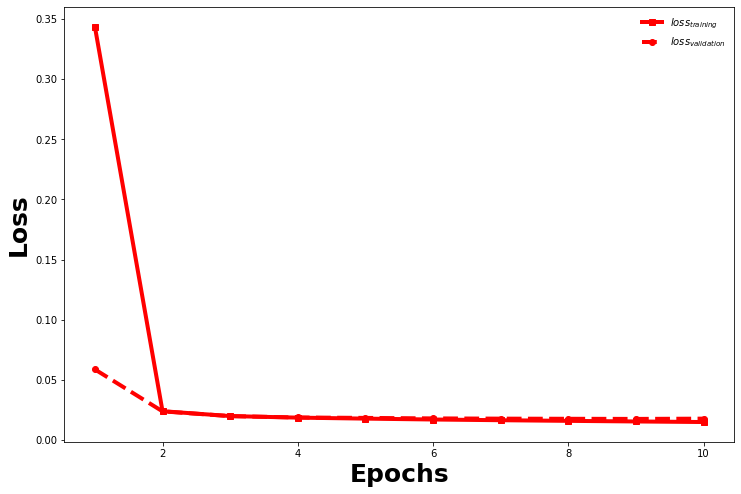

In [51]:
# Get average loss and validation loss out of all folds
mean_loss, mean_val_loss = get_average_metrics_out_of_cv_folds(hist_total_list)

# Plot Loss and Accuracy vs. Epochs
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1,len(mean_loss)+1,1),np.array(mean_loss),'-s',lw=4,label=r'$loss_{training}$',c='r')
plt.plot(np.arange(1,len(mean_val_loss )+1,1),np.array(mean_val_loss ),'--o',lw=4,label=r'$loss_{validation}$',c='r')
plt.ylabel('Loss',fontsize = 25,fontweight='bold')
plt.xlabel("Epochs",fontsize = 25,fontweight='bold')
plt.legend(loc=1,frameon=False)
plt.show()